In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import wasserstein_distance, gaussian_kde
import seaborn as sns
from scipy.stats import skew, kurtosis
import gymnasium as gym
from gymnasium import spaces
from torch.nn import functional as F
from sb3_contrib import RecurrentPPO
from typing import Callable
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from scipy.stats import entropy
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

DATA

In [5]:
power_data = pd.read_csv('processed_power_data.csv')

def create_sequences(data, seq_length, stride, change_type='pct'):
    # Calculate changes
    if change_type == 'pct':
        # Percentage changes
        changes = pd.Series(data).pct_change(fill_method=None).fillna(0)
    elif change_type == 'delta':
        # Delta differences
        changes = pd.Series(data).diff().fillna(0)
    else:
        print('Wrong Change Type!')
    
    # Create sequences
    sequences = []
    for i in range(0, len(changes) - seq_length, stride):
        sequence = changes[i:i + seq_length]
        # Only include sequences with no missing values
        if not np.isnan(sequence).any():
            sequences.append(sequence)
    
    return np.array(sequences)

delta_data = create_sequences(power_data['Global_active_power'].values, seq_length=52, stride=20, change_type='delta')

#print('Shape:', pct_data.shape)
print('Shape:',delta_data.shape)

Shape: (103761, 52)


In [6]:
token_limit = 2

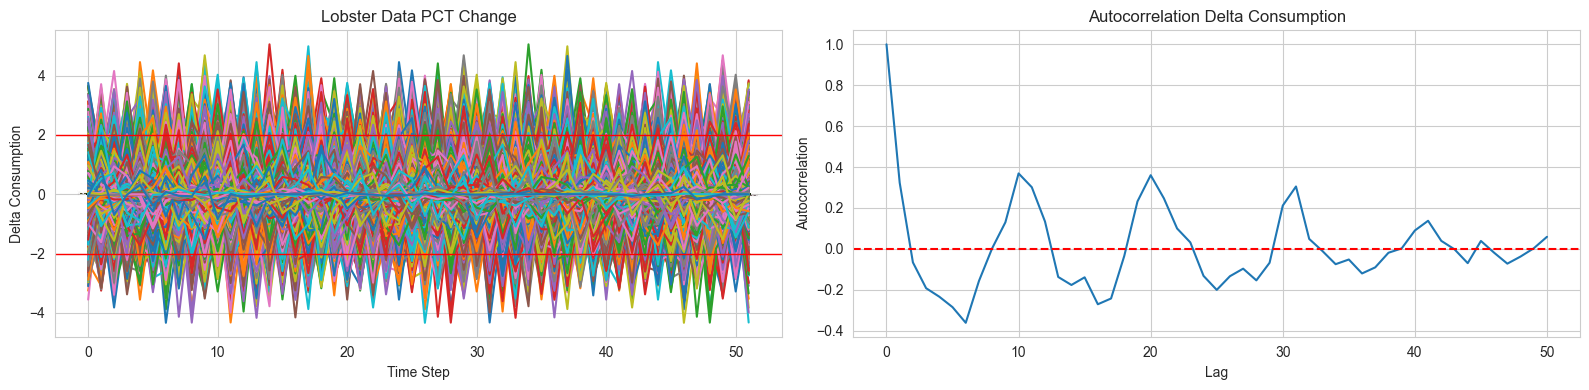

In [7]:
acf_values = acf(delta_data[0], nlags=50)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

ax1.plot(delta_data.T)
ax1.axhline(token_limit, color='red', linewidth=1)
ax1.axhline(-token_limit, color='red', linewidth=1)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Delta Consumption')
ax1.set_title('Electricity Consumption Delta Change')

ax2.plot(range(len(acf_values)), acf_values)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_title('Autocorrelation Delta Consumption')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

FUNCTIONS

In [8]:
def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, _ = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)
    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    return tokenized_sequences

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func

def transfer_weights_from_saved(weights_path, ppo_model, transfer_head, input_dim, hidden_dim, output_dim):
    """
    Load saved supervised weights and transfer to PPO model with optional head transfer
    
    Args:
        weights_path: Path to the saved supervised model weights
        ppo_model: The PPO model to transfer weights to
        transfer_head: If True, also transfer fc layer weights to action_net
        input_dim: Input dimension of the supervised model
        hidden_dim: Hidden dimension of the supervised model
        output_dim: Output dimension of the supervised model
    """
    # Create temporary supervised model to load weights into
    temp_supervised = LSTMModel(input_dim, hidden_dim, output_dim)
    
    # Load the saved weights
    saved_weights = th.load(weights_path, weights_only=False)
    temp_supervised.load_state_dict(saved_weights['model_state_dict'])
    
    
    # Transfer LSTM weights
    print("\n=== Transferring LSTM Weights ===")
    supervised_state_dict = temp_supervised.state_dict()
    ppo_lstm_dict = ppo_model.policy.lstm_actor.state_dict()
    
    # Print shapes before transfer for verification
    print("\nWeight shapes before transfer:")
    print("\nSupervised LSTM weights:")
    for key, value in supervised_state_dict.items():
        if 'lstm' in key:
            print(f"{key}: {value.shape}")
    
    print("\nPPO LSTM weights:")
    for key, value in ppo_lstm_dict.items():
        print(f"{key}: {value.shape}")
    
    # Transfer LSTM weights
    lstm_transfer_count = 0
    for ppo_key in ppo_lstm_dict.keys():
        supervised_key = f"lstm.{ppo_key}"
        if supervised_key in supervised_state_dict:
            if ppo_lstm_dict[ppo_key].shape == supervised_state_dict[supervised_key].shape:
                ppo_lstm_dict[ppo_key].copy_(supervised_state_dict[supervised_key])
                lstm_transfer_count += 1
                print(f"Transferred weights for {ppo_key}")
            else:
                print(f"Shape mismatch for {ppo_key}")
    
    # Load the LSTM weights
    ppo_model.policy.lstm_actor.load_state_dict(ppo_lstm_dict)
    print(f"\nSuccessfully transferred {lstm_transfer_count} LSTM weight tensors")
    
    # Transfer head weights if requested
    if transfer_head:
        print("\n=== Transferring Head Weights ===")
        # Get supervised fc weights and biases
        fc_weight = supervised_state_dict['fc.weight']
        fc_bias = supervised_state_dict['fc.bias']
        
        # Get PPO action_net weights and biases
        action_net_state_dict = ppo_model.policy.action_net.state_dict()
        
        print("\nHead weight shapes:")
        print(f"Supervised fc weight: {fc_weight.shape}")
        print(f"Supervised fc bias: {fc_bias.shape}")
        print(f"PPO action_net weight: {action_net_state_dict['weight'].shape}")
        print(f"PPO action_net bias: {action_net_state_dict['bias'].shape}")
        
        # Verify shapes match before transfer
        if (fc_weight.shape == action_net_state_dict['weight'].shape and 
            fc_bias.shape == action_net_state_dict['bias'].shape):
            # Transfer weights
            action_net_state_dict['weight'].copy_(fc_weight)
            action_net_state_dict['bias'].copy_(fc_bias)
            ppo_model.policy.action_net.load_state_dict(action_net_state_dict)
            print("Successfully transferred head weights")
        else:
            print("Shape mismatch in head weights - transfer aborted")
    
    return ppo_model


In [9]:
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(delta_data)),5))

Standard Deviation of Price Deltas: 0.26555


In [10]:
bin_width = np.std(np.concatenate(delta_data)) / 32
bin_start=-token_limit
bin_stop=token_limit
token_size = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins

token_data = tokenize_deltas(delta_data, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

In [11]:
def plot_price_token(price_data, token_data, bins, token_limit):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    ax1, ax2, ax3, ax4 = axes.ravel()

    # Time Series
    ax1.plot(price_data.T)
    ax1.axhline(token_limit, color='red', linewidth=1)
    ax1.axhline(-token_limit, color='red', linewidth=1)
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Delta Consumption')
    ax1.set_title('Time Series')

    # Boxplot Time Series
    ax2.boxplot(np.concatenate(price_data), vert=True)
    ax2.axhline(token_limit, color='red', linewidth=1)
    ax2.axhline(-token_limit, color='red', linewidth=1)
    ax2.set_title('Boxplot Delta Consumption')
    ax2.set_ylabel('Delta Consumption')

    # Histogram
    ax3.hist(np.concatenate(token_data), bins=bins, edgecolor='blue', color='orange', density=True)
    ax3.set_title('Histogram: Electricity Data Delta Consumption')
    ax3.set_xlabel('Delta Consumption')
    ax3.set_ylabel('Frequency')

    # 99% Data Histogram
    ax4.hist(np.concatenate(token_data), bins=bins, edgecolor='orange', color='blue', density=True)
    ax4.set_xlim(np.quantile(np.concatenate(token_data), q=0.025),np.quantile(np.concatenate(token_data), q=0.975))
    #ax4.set_xlim(np.quantile(np.concatenate(token_data), q=0.005),np.quantile(np.concatenate(token_data), q=0.995))
    ax4.set_title('Histogram: 99% of Data')
    ax4.set_xlabel('Delta Consumption')
    ax4.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def supervised_wasserstein(real_data, supervised_data):
    n_timesteps = real_data.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_data[:, t], supervised_data[:, t])
        wasserstein_supervised.append(w_dist)

    # Create visualization
    fig = plt.figure(figsize=(12, 4))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 2)
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    ax1.legend()

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_data[:, worst_timestep_supervised]
    generated_data = supervised_data[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()

def plot_first_n_distributions(real_data, supervised_data, n_steps=10):
    # Create visualization
    plots_per_row = 5
    rows = (n_steps + plots_per_row - 1) // plots_per_row  # Calculate number of rows needed (ceiling division)
    
    fig = plt.figure(figsize=(30, 4 * rows))  # Adjusted figure size to account for 5 plots per row
    gs = plt.GridSpec(rows, plots_per_row)
    
    for t in range(n_steps):
        # Calculate subplot position
        row = t // plots_per_row
        col = t % plots_per_row
        
        # Create subplot
        ax = fig.add_subplot(gs[row, col])
        
        # Get data for the timestep
        real_timestep = real_data[:, t]
        generated_timestep = supervised_data[:, t]
        
        # Calculate KDE
        kde_real = gaussian_kde(real_timestep)
        kde_generated = gaussian_kde(generated_timestep)
        
        # Create evaluation points
        x_eval = np.linspace(min(real_timestep.min(), generated_timestep.min()),
                            max(real_timestep.max(), generated_timestep.max()),
                            200)
        
        # Plot distributions
        ax.plot(x_eval, kde_real(x_eval), label='Real', color='blue', linewidth=0.8)
        ax.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red', linewidth=0.8)
        ax.set_title(f'Timestep {t}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_autocorrelations(X_train, supervised_data, nlags=10):
    plt.figure(figsize=(10, 6))
    
    # Real data autocorrelation
    acf_real = acf(X_train[:, 1:].flatten(), nlags=nlags)
    plt.plot(range(len(acf_real)), acf_real, linewidth=1.5, label='Real Data')
    
    # Supervised (generated) data autocorrelation
    acf_supervised = acf(supervised_data.flatten(), nlags=nlags)
    plt.plot(range(len(acf_supervised)), acf_supervised, linewidth=1.5, label='Generated Data')
    
    plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
    plt.title('Autocorrelation Comparison')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_losses(pg_loss, value_loss, entropy_loss):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(pg_loss, color='blue')
    axs[0].set_title('Policy Loss')
    axs[0].set_xlabel('Model Update')
    axs[0].set_ylabel('Value')

    axs[1].plot(value_loss, color='blue')
    axs[1].set_title('Value Loss')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(entropy_loss, color='blue')
    axs[2].set_title('Entropy Loss')
    axs[2].set_xlabel('Model Update')
    axs[2].set_ylabel('Value')
    
    #plt.tight_layout()
    plt.show()

def plot_sequence_metrics(ep_rew, wasserstein, kl_div):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(ep_rew, color='blue')
    axs[0].set_title('Episode Reward')
    axs[0].set_ylabel('Reward')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(wasserstein, color='blue')
    axs[1].set_title('Wasserstein Distance')
    axs[1].set_ylabel('WS Distance')
    axs[1].set_xlabel('Model Update')

    axs[2].plot(kl_div, color='blue')
    axs[2].set_title('KL Div. real vs. sim sequences')
    axs[2].set_ylabel('KL Divergence')
    axs[2].set_xlabel('Model Update')

    plt.show()

def plot_discriminator(disc_loss, disc_acc, disc_acc_diff):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()

    axs[0].plot(disc_loss, color='blue')
    axs[0].set_title('Discriminator Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(disc_acc, color='lightblue')
    axs[1].axhline(0.5, color='red', linestyle='--', linewidth=1.5)
    axs[1].set_title('Discriminator Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylim(0,1.0)

    axs[2].plot(disc_acc_diff, color='blue')
    axs[2].set_title('Accuracy difference: First vs. Second half of Sequence')
    axs[2].set_ylabel('Accuracy Difference')
    axs[2].set_xlabel('Episode')
    
    plt.show()



def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
    
    return means, variances, std_devs, skewness, kurtos

def plot_three_moments(supervised_means, real_means, bin_edges_mean,
                       supervised_variances, real_variances, bin_edges_var,
                       supervised_skew, real_skew, bin_edges_skew,
                       gail_means, gail_variances, gail_skew):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))

    # Plot 1: Mean Distribution
    axs[0].hist(supervised_means, bins=bin_edges_mean, alpha=0.8, label='Supervised', color='red')
    axs[0].hist(gail_means, bins=bin_edges_mean, alpha=0.8, label='GAIL', color='green')
    axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Mean')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')

    # Plot 1: Variance Distribution
    axs[1].hist(supervised_variances, bins=bin_edges_var, alpha=0.8, label='Supervised', color='red')
    axs[1].hist(gail_variances, bins=bin_edges_var, alpha=0.8, label='GAIL', color='green')
    axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Value')
    axs[1].tick_params(labelleft=False)

    # Plot 2: Skewness Distribution
    axs[2].hist(supervised_skew, bins=bin_edges_skew, alpha=0.8, label='Supervised', color='red')
    axs[2].hist(gail_skew, bins=bin_edges_skew, alpha=0.8, label='GAIL', color='green')
    axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
    axs[2].legend(loc='upper right')
    axs[2].set_title('Skewness')
    axs[2].set_xlabel('Value')
    axs[2].tick_params(labelleft=False)
    plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def plot_sequences(real_seq, supervised, gail, token_size):
    # Create the subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.2))  # 1 row, 3 columns
    axes = axes.flatten()

    # Plot the real and simulated trajectories
    for i in range(3):
        axes[i].plot(real_seq[i][1:], label='Real Trajectory', color='skyblue')
        axes[i].plot(supervised[i], label='Supervised', color='red')
        axes[i].plot(gail[i], label='GAIL', color='green')
        axes[i].legend(loc='best', prop={'size': 10})
        axes[i].set_title(f'Trajectory {i+1}')
        axes[i].set_ylim(0-10, token_size+10)
        axes[i].set_xlabel('Time Step')
        
        if i == 0:  # Only set y-axis label on the first plot
            axes[i].set_ylabel('Price Delta')
        else:
            axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

    # Adjust spacing between plots to bring them closer
    plt.subplots_adjust(wspace=0)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def wasserstein_dist(real_sequences, supervised, gail):

    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    wasserstein_gail = []

    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], supervised[:, t])
        wasserstein_supervised.append(w_dist)
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], gail[:, t])
        wasserstein_gail.append(w_dist)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 3.5))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 3)
    
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.plot(wasserstein_gail, label = 'GAIL')
    ax1.legend()
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_supervised]
    generated_data = supervised[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()

    # Plot 3: Compare specific timesteps
    ax3 = fig.add_subplot(gs[0, 2])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_gail = np.argmax(wasserstein_gail)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_gail]
    generated_data = gail[:, worst_timestep_gail]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax3.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax3.plot(x_eval, kde_generated(x_eval), label='GAIL', color='green')
    ax3.set_title(f'Distribution Comparison at Timestep {worst_timestep_gail}\n'
                f'(Largest Wasserstein Distance)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()



def distribution_evolution(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histogram for each timestep
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    # Define common range for all histograms
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max for color scaling
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create visualization
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()

def distribution_evolution_strong_contrast(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histograms (same as before)
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create custom normalization to enhance color contrast
    # Option 1: Using power-law normalization
    from matplotlib.colors import PowerNorm
    norm = PowerNorm(gamma=0.5)  # gamma < 1 will enhance lower values
    
    # Option 2: Alternative - use LogNorm for even more contrast
    # from matplotlib.colors import LogNorm
    # norm = LogNorm(vmin=max(vmin, 0.001), vmax=vmax)  # avoid log(0)
    
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()

def token_distribution_distance(real_seq, generated_seq, n_tokens):
    """
    Calculate average Jensen-Shannon distance between token distributions at each timestep.
    """
    n_timesteps = real_seq.shape[1]
    distances = []
    
    for t in range(n_timesteps):
        # Calculate frequencies for this timestep
        freq1 = np.bincount(real_seq[:, t].astype(int), minlength=n_tokens) / len(real_seq)
        freq2 = np.bincount(generated_seq[:, t].astype(int), minlength=n_tokens) / len(generated_seq)
        
        # Add small epsilon to avoid log(0)
        freq1 += 1e-10
        freq2 += 1e-10
        
        # Normalize
        freq1 /= freq1.sum()
        freq2 /= freq2.sum()
        
        # Calculate Jensen-Shannon distance
        m = 0.5 * (freq1 + freq2)
        js_distance = 0.5 * (entropy(freq1, m) + entropy(freq2, m))
        distances.append(np.sqrt(js_distance))
    
    return np.mean(distances)

def transition_matrix_difference(real_seq, generated_seq, n_tokens):
    """
    Calculate average difference between transition matrices across timesteps.
    """
    def get_transition_matrices(sequence):
        n_timesteps = sequence.shape[1]
        transitions = []
        
        for t in range(n_timesteps - 1):
            current_tokens = sequence[:, t].astype(int)
            next_tokens = sequence[:, t + 1].astype(int)
            
            # Create transition matrix for this timestep
            trans_matrix = np.zeros((n_tokens, n_tokens))
            for curr, next_t in zip(current_tokens, next_tokens):
                trans_matrix[curr, next_t] += 1
            
            # Normalize
            row_sums = trans_matrix.sum(axis=1)
            row_sums[row_sums == 0] = 1
            trans_matrix = trans_matrix / row_sums[:, np.newaxis]
            transitions.append(trans_matrix)
            
        return transitions
    
    trans_real = get_transition_matrices(real_seq)
    trans_gen = get_transition_matrices(generated_seq)
    
    differences = [np.mean(np.abs(r - g)) for r, g in zip(trans_real, trans_gen)]
    return np.mean(differences)

def pattern_similarity_score(real_seq, generated_seq, window_size=5):
    """
    Calculate pattern similarity across the sequences.
    """
    def get_pattern_distribution(seq, window_size):
        n_samples = seq.shape[0]
        n_timesteps = seq.shape[1]
        patterns = []
        
        # Get patterns for each sample
        for i in range(n_samples):
            for t in range(n_timesteps - window_size + 1):
                pattern = tuple(seq[i, t:t+window_size].astype(int))
                patterns.append(pattern)
        
        unique, counts = np.unique(patterns, axis=0, return_counts=True)
        return dict(zip(map(tuple, unique), counts / len(patterns)))
    
    # Get distributions
    dist1 = get_pattern_distribution(real_seq, window_size)
    dist2 = get_pattern_distribution(generated_seq, window_size)
    
    # Get all unique patterns
    all_patterns = set(dist1.keys()) | set(dist2.keys())
    
    # Calculate Euclidean distance
    squared_diff_sum = 0
    for pattern in all_patterns:
        prob1 = dist1.get(pattern, 0)
        prob2 = dist2.get(pattern, 0)
        squared_diff_sum += (prob1 - prob2) ** 2
    
    return np.sqrt(squared_diff_sum)

def compare_sequences(real_data, supervised_data, gail_data, n_tokens):
    """
    Compare supervised and GAIL sequences against real data.
    """
    metrics = {
        'Method': ['Supervised', 'GAIL'],
        'Distribution Distance': [
            token_distribution_distance(real_data, supervised_data, n_tokens),
            token_distribution_distance(real_data, gail_data, n_tokens)
        ],
        'Transition Difference': [
            transition_matrix_difference(real_data, supervised_data, n_tokens),
            transition_matrix_difference(real_data, gail_data, n_tokens)
        ],
        'Pattern Similarity': [
            pattern_similarity_score(real_data, supervised_data),
            pattern_similarity_score(real_data, gail_data)
        ]
    }
    
    results_df = pd.DataFrame(metrics)
    
    # Print formatted results
    print("\nComparison Results:")
    print("==================")
    print(results_df.to_string(index=False))
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    metrics_to_plot = ['Distribution Distance', 'Transition Difference', 'Pattern Similarity']
    
    bar_width = 0.35
    x = np.arange(len(metrics_to_plot))
    
    plt.bar(x - bar_width/2, results_df.iloc[0, 1:], bar_width, label='Supervised')
    plt.bar(x + bar_width/2, results_df.iloc[1, 1:], bar_width, label='GAIL')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score (lower is better)')
    plt.title('Comparison of Supervised vs GAIL Generation')
    plt.xticks(x, metrics_to_plot, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results_df

def wasserstein_dist_new(real_sequences, supervised, gail):
    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    wasserstein_gail = []

    for t in range(n_timesteps):
        # Calculate standard deviation of real data at this timestep
        real_var = np.std(real_sequences[:, t])
        
        # Calculate Wasserstein distance and normalize by standard deviation
        w_dist_supervised = wasserstein_distance(real_sequences[:, t], supervised[:, t])
        w_dist_gail = wasserstein_distance(real_sequences[:, t], gail[:, t])
        
        # Store normalized distances (as percentages)
        wasserstein_supervised.append((w_dist_supervised / real_var))
        wasserstein_gail.append((w_dist_gail / real_var))
    
    # Create visualization
    fig = plt.figure(figsize=(6, 3.5))
    gs = plt.GridSpec(1, 1)
    
    # Plot with updated y-axis label
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label="Supervised")
    ax1.plot(wasserstein_gail, label='GAIL')
    ax1.legend()
    ax1.set_title('Normalized Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance (% of SD)')
    ax1.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=1))

def plot_n_distributions(real_data, supervised_data, gail_data, n_steps=10):
    # Create visualization
    plots_per_row = 5
    rows = (n_steps + plots_per_row - 1) // plots_per_row
    
    fig = plt.figure(figsize=(20, 4 * rows))
    gs = plt.GridSpec(rows, plots_per_row)
    
    for t in range(n_steps):
        # Calculate subplot position
        row = t // plots_per_row
        col = t % plots_per_row
        
        # Create subplot
        ax = fig.add_subplot(gs[row, col])
        
        # Get data for the timestep
        real_timestep = real_data[:, t]
        supervised_timestep = supervised_data[:, t]
        gail_timestep = gail_data[:, t]
        
        # Calculate KDE
        kde_real = gaussian_kde(real_timestep)
        kde_supervised = gaussian_kde(supervised_timestep)
        kde_gail = gaussian_kde(gail_timestep)
        
        # Create evaluation points
        x_eval = np.linspace(
            min(real_timestep.min(), supervised_timestep.min(), gail_timestep.min()),
            max(real_timestep.max(), supervised_timestep.max(), gail_timestep.max()),
            200
        )
        
        # Plot distributions
        ax.plot(x_eval, kde_real(x_eval), label='Real', color='blue', linewidth=0.8)
        ax.plot(x_eval, kde_supervised(x_eval), label='Supervised', color='red', linewidth=0.8)
        ax.plot(x_eval, kde_gail(x_eval), label='GAIL', color='green', linewidth=0.8)
        ax.set_title(f'Timestep {t}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


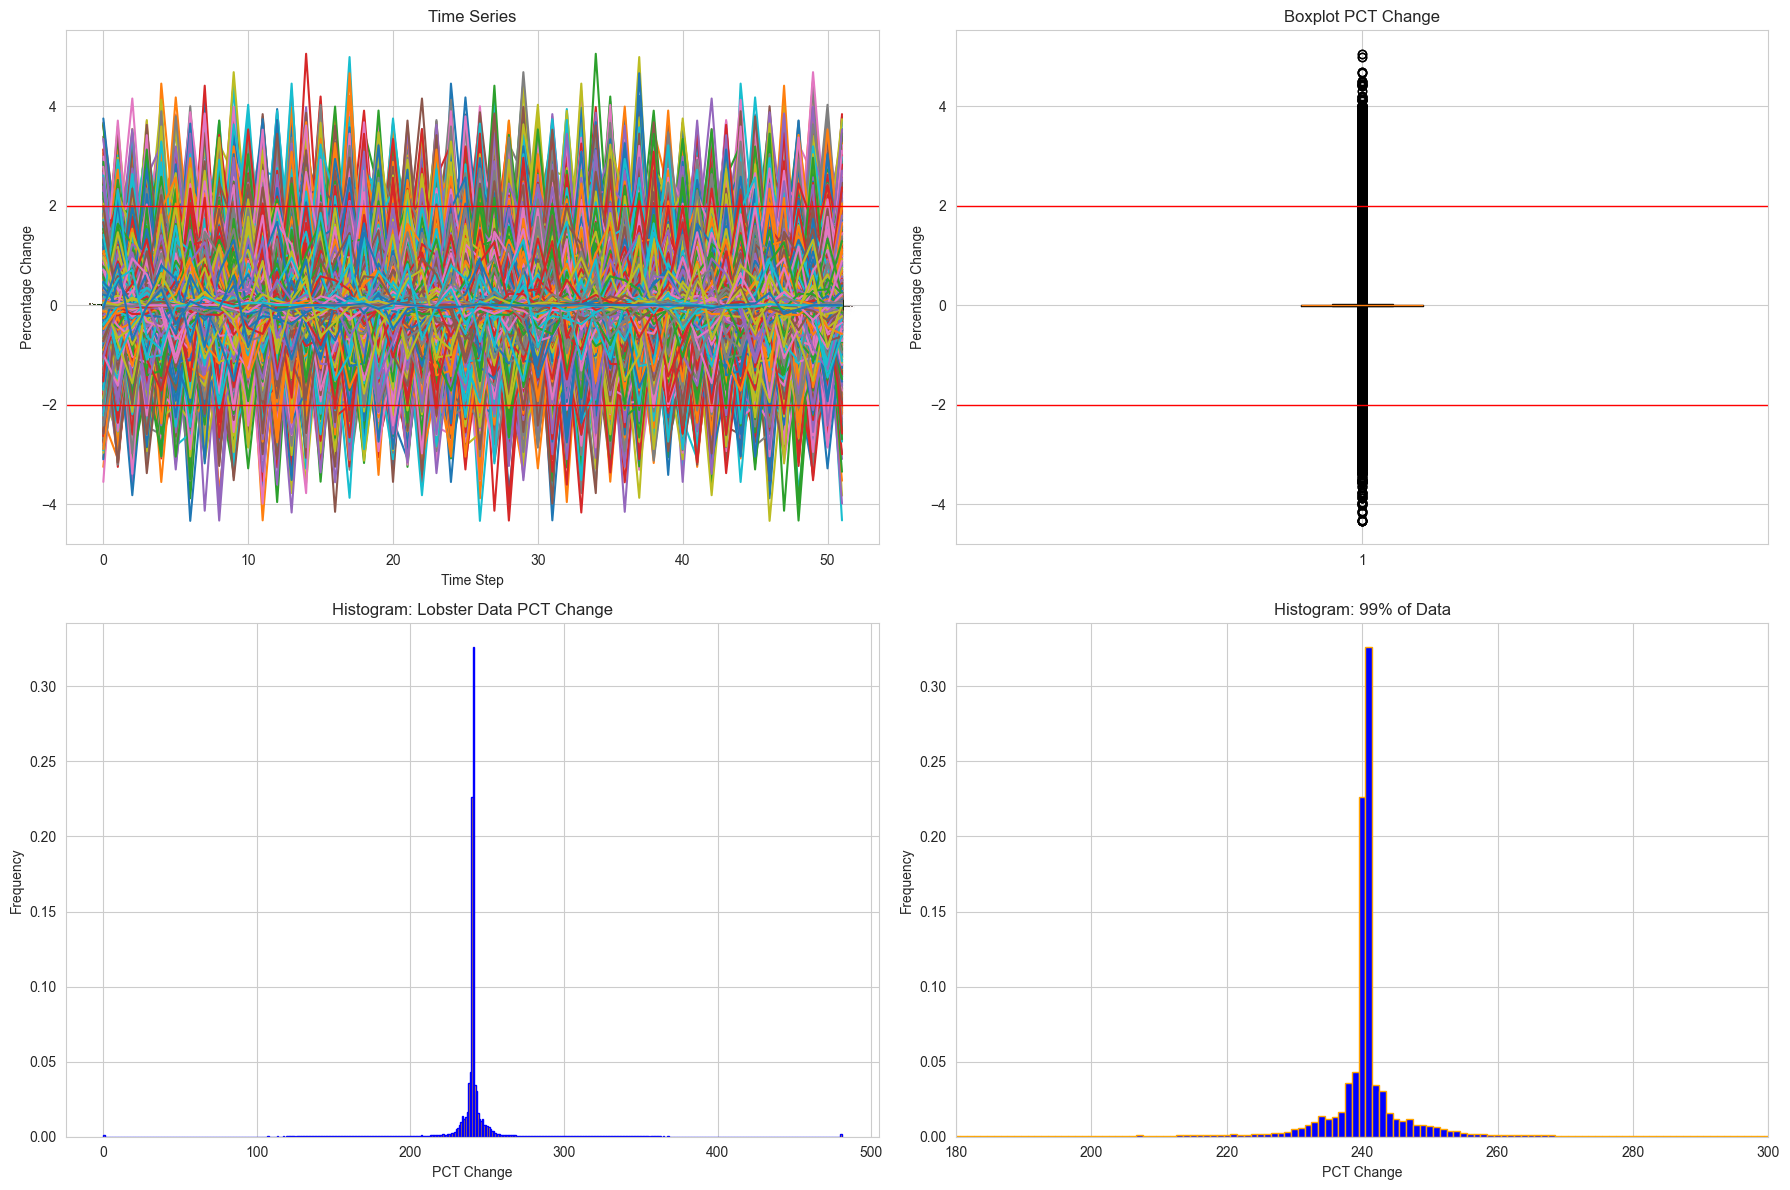

Number of Tokens: 482
Data Shape: (103761, 52)


In [12]:
plot_price_token(price_data=delta_data, token_data=token_data, bins=token_size, token_limit=token_limit)

print('Number of Tokens:', token_size)
print('Data Shape:', delta_data.shape)

In [13]:
n_sequences = delta_data.shape[0]
n_days = delta_data.shape[1] 

train_ratio = 0.75
# Chronological splitting
train_size = int(train_ratio * n_sequences)
val_size = int((1-train_ratio)/2 * n_sequences)

# Split maintaining temporal order
train_set = delta_data[:train_size]
val_set = delta_data[train_size:train_size+val_size]
test_set = delta_data[train_size+val_size:]

X_train = tokenize_deltas(train_set, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)
X_val = tokenize_deltas(val_set, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)
X_test = tokenize_deltas(test_set, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (77820, 52)
Validation set shape: (12970, 52)
Test set shape: (12971, 52)


PARAMETERS

In [16]:
# Rest of your parameters remain the same
hidden_dim = 128
batch_size = 256
learning_rate = 2e-4
seq_len = n_days-1
num_epochs = 30
hidden_layers = 2

sw_pretraining = 'sw_pretrain_50.pth'
sw_posttraining = 'sw_posttrain_50.pth'
gail_training = "GAIL_weights_50.zip"

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Changed default input_dim
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=hidden_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # x shape now: [batch_size, sequence_length, vocab_size]
        lstm_out, (h_n, c_n) = self.lstm(x, hidden)
        logits = self.fc(lstm_out)
        return logits, (h_n, c_n)

def to_onehot(tokens, vocab_size):
    """Convert batch of tokens to one-hot vectors using efficient PyTorch operations"""
    batch_size, seq_length = tokens.shape
    # Create indices tensor
    onehot = th.zeros(batch_size, seq_length, vocab_size, device=tokens.device)
    # Use scatter_ for efficient one-hot encoding
    return onehot.scatter_(2, tokens.unsqueeze(-1), 1)

#### SUPERVISED TRAINING

In [18]:
# Create model with new input dimension
model_supervised = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)

criterion_supervised = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_loss = []
val_loss = []

best_val_loss = float('inf')
max_grad_norm = 1.0

# Pre-allocate tensors for validation to avoid repeated creationa
val_input_tokens = th.tensor(X_val[:, :-1], dtype=th.long)
val_targets = th.tensor(X_val[:, 1:], dtype=th.long)
val_onehot = to_onehot(val_input_tokens, token_size)

# Convert training data to tensors once before training loop
train_tokens = th.tensor(X_train, dtype=th.long)

for epoch in range(num_epochs):
    
    temp_train_loss = []
    temp_val_loss = []

    ## ============
    ## TRAINING
    ## ============

    model_supervised.train()
    
    indices = th.randperm(X_train.shape[0])  # Use PyTorch's randperm instead of numpy

    for batch_idx in range(0, X_train.shape[0], batch_size):
        
        
        batch_indices = indices[batch_idx:batch_idx + batch_size]
        batch = train_tokens[batch_indices]

        input_tokens = batch[:, :-1]
        inputs = to_onehot(input_tokens, token_size)
        targets = batch[:, 1:]

        logits, _ = model_supervised(inputs, None)
        logits = logits.reshape(-1, logits.size(-1))
        targets = targets.reshape(-1)

        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        loss = criterion_supervised(logits, targets)
        loss.backward()

        th.nn.utils.clip_grad_norm_(model_supervised.parameters(), max_grad_norm)
        optimizer.step()
        
        temp_train_loss.append(loss.item())

    ## ============
    ## VALIDATION
    ## ============
        
    model_supervised.eval()

    with th.no_grad():
        logits, _ = model_supervised(val_onehot, None)
        logits = logits.reshape(-1, logits.size(-1))
        targets = val_targets.reshape(-1)
        loss = criterion_supervised(logits, targets)
        temp_val_loss.append(loss.item())
        
    if loss.item() < best_val_loss:
        best_val_loss = loss.item()
        checkpoint = {
            'model_state_dict': model_supervised.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }
        th.save(checkpoint, sw_pretraining)
    
    train_loss.extend(temp_train_loss)
    val_loss.append(loss.item())  # Only append the last validation loss
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_train_loss):.4f} - Val Loss: {loss.item():.4f}")

Epoch 1/30 - Train Loss: 3.5989 - Val Loss: 3.0797
Epoch 2/30 - Train Loss: 3.0362 - Val Loss: 2.9971
Epoch 3/30 - Train Loss: 2.9420 - Val Loss: 2.9287
Epoch 4/30 - Train Loss: 2.8825 - Val Loss: 2.8889
Epoch 5/30 - Train Loss: 2.8403 - Val Loss: 2.8526
Epoch 6/30 - Train Loss: 2.8069 - Val Loss: 2.8292
Epoch 7/30 - Train Loss: 2.7791 - Val Loss: 2.7990
Epoch 8/30 - Train Loss: 2.7489 - Val Loss: 2.7721
Epoch 9/30 - Train Loss: 2.7204 - Val Loss: 2.7486
Epoch 10/30 - Train Loss: 2.6986 - Val Loss: 2.7319
Epoch 11/30 - Train Loss: 2.6830 - Val Loss: 2.7208
Epoch 12/30 - Train Loss: 2.6703 - Val Loss: 2.7102
Epoch 13/30 - Train Loss: 2.6600 - Val Loss: 2.7022
Epoch 14/30 - Train Loss: 2.6521 - Val Loss: 2.6978
Epoch 15/30 - Train Loss: 2.6449 - Val Loss: 2.6893
Epoch 16/30 - Train Loss: 2.6388 - Val Loss: 2.6845
Epoch 17/30 - Train Loss: 2.6329 - Val Loss: 2.6823
Epoch 18/30 - Train Loss: 2.6275 - Val Loss: 2.6747
Epoch 19/30 - Train Loss: 2.6209 - Val Loss: 2.6677
Epoch 20/30 - Train L

In [19]:
print(best_val_loss)

2.604400396347046


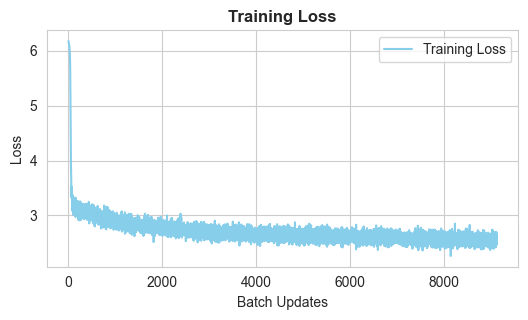

In [20]:
# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_loss, label='Training Loss', color='skyblue', linewidth=1.5)
#plt.plot(val_loss, label='Validation Loss', color='blue', linewidth=1.5)
plt.title('Training Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

INFERENCE

In [21]:
# Update model creation to match new architecture
inference_model = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)
checkpoint = th.load(sw_pretraining)
inference_model.load_state_dict(checkpoint['model_state_dict'])
criterion_inference = nn.CrossEntropyLoss()

test_data_inference = th.tensor(X_test, dtype=th.long)  # Changed to long type

test_losses = []
pre_supervised_data = []

inference_model.eval()

def to_onehot_inference(tokens, vocab_size):
    """Efficient one-hot encoding using scatter"""
    onehot = th.zeros(1, 1, vocab_size)
    return onehot.scatter_(2, tokens.view(1, 1, 1), 1)

with th.no_grad():
    
    for sequence in test_data_inference:
        
        token_loss = 0
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token.item()]  # Store as Python integers
        hidden = None

        last_token = th.zeros(1, dtype=th.long)
        
        for i in range(1, len(sequence)):

            last_token[0] = sim_trajectory[-1]
            input_onehot = to_onehot_inference(last_token, token_size)

            # Get model predictions
            logits, hidden = inference_model(input_onehot, hidden)
            probs = F.softmax(logits, dim=-1).squeeze()

            # Sample next token
            predicted_token = th.multinomial(probs, num_samples=1).item()
            sim_trajectory.append(predicted_token)
            
            # Loss calculation
            true_token = sequence[i].unsqueeze(-1)
            loss = criterion_inference(logits.squeeze(1), true_token.long())
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        pre_supervised_data.append(sim_trajectory[1:])

pre_supervised_data = np.array(pre_supervised_data)

/var/folders/1x/hjv8bl714_xgsbdy8fp5kj140000gn/T/ipykernel_25072/2863177154.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = th.load(sw_pretraining)


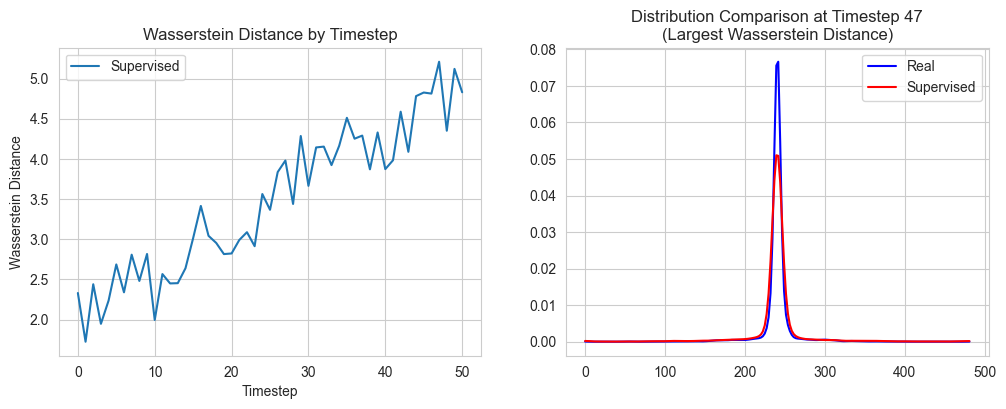

In [22]:
supervised_wasserstein(X_test[:,1:], pre_supervised_data)

In [ ]:
plot_first_n_distributions(X_test[:,1:], pre_supervised_data, n_steps=n_days-2)

#### GAIL

In [ ]:
class LSTM_Discriminator(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTM_Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        logits = self.fc(lstm_out)
        logits = logits.squeeze(-1)
        return logits, hidden

In [ ]:
class CustomEnv(gym.Env):
    
    def __init__(self,
                 token_size, bin_start, bin_stop, bin_width,
                 train_data, val_data,
                 discriminator, d_optimizer):
        
        super(CustomEnv, self).__init__()

        # Spaces
        self.action_space = spaces.Discrete(token_size)        # Action Space
        self.observation_space = spaces.Discrete(token_size)   # Observation Spacepass

        self.num_bins = int((bin_stop - bin_start) / bin_width)
        self.bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

        # Data
        self.train_data = train_data
        self.val_data = val_data
        
        # Discriminator
        self.discriminator = discriminator
        self.d_optimizer = d_optimizer
        self.criterion = nn.BCEWithLogitsLoss()

        # Reset
        self.seq_len = None
        self.curr_seq = []
        self.seq_position = 0
        self.hidden_states = None
    
    def step(self, action):

        assert self.action_space.contains(action), "Invalid Action"

        self.seq_position += 1

        self.curr_seq.append(action)

        ###=====REWARD=====###
        reward = self._get_reward(action)
        ###=====REWARD=====###
        
        done = self._is_done()
        
        next_obs = action

        return next_obs, reward, done, False, {}        # observation, reward, done, truncated, info
    
    def reset(self, *, seed = None, options = None):

        seq_idx = np.random.choice(self.train_data.shape[0], size = 1).item()
        real_seq = self.train_data[seq_idx]
        
        # Reset
        self.seq_len = len(real_seq)
        self.curr_seq = []
        self.seq_position = 0
        self.hidden_states = None
        
        start_token = int(real_seq[0])

        return start_token, {}
    
    def _get_reward(self, action):

        self.discriminator.eval()

        with th.no_grad():
            temp_action = th.tensor(np.array([[action]]), dtype=th.long)
            prediction, self.hidden_states = self.discriminator(temp_action, self.hidden_states)
            prediction = prediction[0,0]
            label = th.ones_like(prediction)
            seq_loss = self.criterion(prediction, label)
            reward = -(seq_loss.item())
            return reward

    def _is_done(self):

        return self.seq_position == (self.seq_len - 1)

    def get_train_sequence(self):
        seq_idx = np.random.choice(self.train_data.shape[0], size = 1).item()
        real_seq = self.train_data[seq_idx]
        return real_seq
    
    def get_val_sequence(self):
        seq_idx = np.random.choice(self.val_data.shape[0], size = 1).item()
        real_seq = self.val_data[seq_idx]
        return real_seq

    def discriminator_accuracy(self, real_data, fake_data):
        
        self.discriminator.eval()
        
        with th.no_grad():
            batch_real = th.tensor(real_data, dtype=th.long)
            batch_fake = th.tensor(fake_data, dtype=th.long)
            
            seq_len = batch_real.size(1)
            split_idx = seq_len // 2
            
            # Full sequence predictions
            real_preds, _ = self.discriminator(batch_real, None)
            fake_preds, _ = self.discriminator(batch_fake, None)
            
            real_probs = th.sigmoid(real_preds)
            fake_probs = th.sigmoid(fake_preds)
            
            # Full accuracy
            correct_real = (real_probs > 0.5).float().sum()
            correct_fake = (fake_probs < 0.5).float().sum()
            total = real_probs.numel() + fake_probs.numel()
            acc_full = (correct_real + correct_fake) / total
            
            # First half accuracy
            correct_real_first = (real_probs[:split_idx] > 0.5).float().sum()
            correct_fake_first = (fake_probs[:split_idx] < 0.5).float().sum()
            total_first = real_probs[:split_idx].numel() + fake_probs[:split_idx].numel()
            acc_1 = (correct_real_first + correct_fake_first) / total_first
            
            # Second half accuracy
            correct_real_second = (real_probs[split_idx:] > 0.5).float().sum()
            correct_fake_second = (fake_probs[split_idx:] < 0.5).float().sum()
            total_second = real_probs[split_idx:].numel() + fake_probs[split_idx:].numel()
            acc_2 = (correct_real_second + correct_fake_second) / total_second
            
            return acc_full.item(), acc_1.item(), acc_2.item(), (acc_2 - acc_1).item()
    
    def train_discriminator(self, batch_real, batch_fake):
        
        self.discriminator.train()
        
        batch_real = th.tensor(batch_real, dtype=th.long)
        batch_fake = th.tensor(batch_fake, dtype=th.long)

        # Forward pass - real data
        real_preds, _ = self.discriminator(batch_real, None)
        real_preds = real_preds.view(-1)
        real_labels = th.ones_like(real_preds) * 0.9  # Label smoothing
        real_loss = self.criterion(real_preds, real_labels)

        # Forward pass - fake data
        fake_preds, _ = self.discriminator(batch_fake, None)
        fake_preds = fake_preds.view(-1)
        fake_labels = th.ones_like(fake_preds) * 0.1  # Label smoothing
        fake_loss = self.criterion(fake_preds, fake_labels)

        # Combined loss and update
        d_loss = (real_loss + fake_loss) / 2
        self.d_optimizer.zero_grad()
        d_loss.backward()
        th.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=0.5)  # Add gradient clipping
        self.d_optimizer.step()

        with th.no_grad():
            discriminator_loss = d_loss.item()
        
        return discriminator_loss


In [ ]:
class CustomCallback(BaseCallback):

    def __init__(self, verbose, display_rollout, disc_batch_size):
        
        super(CustomCallback, self).__init__(verbose)

        self.val_size = None
        
        # Display Rollout
        self.display_rollout = display_rollout
        # Losses
        self.pg_losses, self.value_losses, self.entropy_losses = [], [], []
        # Rewards
        self.rewards = []
        
        self.batch_size = disc_batch_size

        # KL and Wasserstein
        self.sequence_metrics = {
            'kl_div': [],
            'wasserstein': []
        }

        # Metrics after every network update of the discriminator
        self.disc_metrics_per_batch = {
            'loss': [], 
            'accuracy': [],
            'accuracy_1': [],
            'accuracy_2': [],
            'accuracy_difference': [],
            'n_batches': []
        }

        # Save best model
        self.best_wasserstein = float('inf')  # Initialize with infinity
        self.best_model_path = gail_training   # Path to save best model

    def _on_training_start(self) -> None:
        
        self.val_size = self.training_env.envs[0].unwrapped.val_data.shape[0]    

    def _on_rollout_start(self) -> None:
        
        self.save_losses()

        real_data, fake_data = self.get_sequences(n = self.val_size, train = False)

        wasser_dist = self.calculate_wasserstein_distance(real_data, fake_data)
        kl_div = self.calculate_kl_divergence(real_data, fake_data)

        self.sequence_metrics['wasserstein'].append(wasser_dist)
        self.sequence_metrics['kl_div'].append(kl_div)

        # Save model if we have a new best Wasserstein distance
        if wasser_dist < self.best_wasserstein:
            self.best_wasserstein = wasser_dist
            print(f"\nNew best Wasserstein distance: {wasser_dist:.3f}, saving model...")
            self.model.save(f"{self.best_model_path}")

        for env in self.training_env.envs:

            pre_acc, _, _, pre_diff = env.unwrapped.discriminator_accuracy(real_data, fake_data)

            metrics = {
                'losses': [], 
                'accuracies': [],
                'pre_acc': 0,
                'post_acc': 0
                }

            max_accuracy = 0.75     # Don't want discriminator too strong
            min_batches = 10        # Minimum batches to train on
            max_batches = 100       # Minimum batches to train on

            # Dynamic batch sizing
            curr_batch_size = batch_size
            if pre_acc < 0.55:  # If discriminator is very weak
                curr_batch_size = batch_size * 2  # Train on more data
            
            for batch in range(max_batches):
                
                real_batch, fake_batch = self.get_sequences(n=curr_batch_size, train=True)
                batch_loss = env.unwrapped.train_discriminator(real_batch, fake_batch)
                curr_acc, curr_acc_1, curr_acc_2, curr_acc_diff = env.unwrapped.discriminator_accuracy(real_batch, fake_batch)

                metrics['losses'].append(batch_loss)
                metrics['accuracies'].append(curr_acc)
                
                self.disc_metrics_per_batch['loss'].append(batch_loss)
                self.disc_metrics_per_batch['accuracy'].append(curr_acc)
                self.disc_metrics_per_batch['accuracy_1'].append(curr_acc_1)
                self.disc_metrics_per_batch['accuracy_2'].append(curr_acc_2)
                self.disc_metrics_per_batch['accuracy_difference'].append(curr_acc_diff)

                if batch >= min_batches:

                    if curr_acc > max_accuracy:
                        print(f"Discriminator too strong ({curr_acc:.3f}), stopping")
                        break

                    recent_acc = np.mean(metrics['accuracies'][-3:])  # Last 3 batches
                    if 0.60 < recent_acc < 0.75 and np.std(metrics['accuracies'][-3:]) < 0.02:
                        print(f"Discriminator stable at {recent_acc:.3f}, stopping")
                        break

                    # Stop if no improvement in last 5 batches
                    if batch > 10 and np.std(metrics['accuracies'][-10:]) < 0.01:
                        print("Discriminator converged, stopping")
                        break
                
                # Adjust batch size if needed
                if batch % 10 == 0:  # Every 10 batches
                    if curr_acc < 0.60:  # Still too weak
                        curr_batch_size = min(curr_batch_size * 2, 256)  # Increase data
                    elif curr_acc > 0.80:  # Getting too strong
                        curr_batch_size = max(curr_batch_size // 2, n_sequences)  # Decrease data
                
            self.disc_metrics_per_batch['n_batches'].append(batch + 1)
            
            post_acc, _, _, post_diff = env.unwrapped.discriminator_accuracy(real_data, fake_data)

            print(f"Wasserstein: {wasser_dist:.3f} - KL Div: {kl_div:.3f} - Stopped after {batch + 1} batches")
            print(f"Pre Accuracy: {pre_acc:.3f} - Post Accuracy: {post_acc:.3f} - Pre Acc Diff: {pre_diff:.3f} - Post Acc Diff: {post_diff:.3f}")
    
    def _on_step(self) -> bool:

        return True

    def _on_rollout_end(self) -> None:

        if self.display_rollout:
            self.display_rollout_buffer()
        
        self.save_reward()
    
    def _on_training_end(self) -> None:
        
        self.save_losses()

    def save_losses(self) -> None:
        self.pg_losses.append(self.logger.name_to_value.get('train/policy_gradient_loss', None))
        self.value_losses.append(self.logger.name_to_value.get('train/value_loss', None))
        self.entropy_losses.append(self.logger.name_to_value.get('train/entropy_loss', None))

    def save_reward(self):
        # Get rewards without reshaping
        rewards = self.model.rollout_buffer.rewards  # Shape: (n_steps, n_envs)
        episode_starts = self.model.rollout_buffer.episode_starts
        
        all_sequence_rewards = []
        
        # Process each environment separately
        for env_idx in range(self.training_env.num_envs):
            # Get rewards and episode starts for this environment
            env_rewards = rewards[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            if not env_starts[0]:
                ep_start_idx = np.r_[0, ep_start_idx]
                
            # Calculate rewards for this env's sequences
            sequence_rewards = np.add.reduceat(env_rewards, np.r_[0, ep_start_idx[1:]])
            all_sequence_rewards.extend(sequence_rewards)
        
        # Store average across all envs
        self.rewards.append(np.mean(all_sequence_rewards))

    def display_rollout_buffer(self):
        print("\nRollout Buffer Contents:")
        
        # Get original shaped arrays
        observations = self.model.rollout_buffer.observations  # Shape: (n_steps, n_envs)
        actions = self.model.rollout_buffer.actions
        rewards = self.model.rollout_buffer.rewards
        returns = self.model.rollout_buffer.returns
        episode_starts = self.model.rollout_buffer.episode_starts
        values = self.model.rollout_buffer.values
        log_probs = self.model.rollout_buffer.log_probs
        advantages = self.model.rollout_buffer.advantages
        
        # Print header with line
        header = "  env_id    step    observations  actions  rewards  returns  episode_starts  values  log_probs  advantages"
        print("-" * (len(header) + 5))
        print(header)
        print("-" * (len(header) + 5))
        
        # For each environment
        for env_idx in range(self.training_env.num_envs):
            # Get data for this environment
            env_obs = observations[:, env_idx]
            env_actions = actions[:, env_idx]
            env_rewards = rewards[:, env_idx]
            env_returns = returns[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            env_values = values[:, env_idx]
            env_log_probs = log_probs[:, env_idx]
            env_advantages = advantages[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            
            # Print rows for this environment
            last_idx = -1
            for step in range(len(env_obs)):
                if step in ep_start_idx:
                    if last_idx != -1:
                        print("=" * (len(header) + 5))
                    print(f"Environment {env_idx} - New Episode")
                    print("-" * (len(header) + 5))
                
                # Convert arrays to strings or get first element if array
                obs_str = str(env_obs[step].item()) if hasattr(env_obs[step], 'item') else str(env_obs[step])
                action_str = str(env_actions[step].item()) if hasattr(env_actions[step], 'item') else str(env_actions[step])
                
                print(
                    f"Obs: {obs_str:8s}  "
                    f"Act: {action_str:4s}  "
                    f"Rew: {env_rewards[step]:6.2f}  "
                    f"Ret: {env_returns[step]:7.2f}  "
                    f"Start: {int(env_starts[step]):1d}  "
                    f"Val: {env_values[step]:6.2f}  "
                    f"LogP: {env_log_probs[step]:8.2f}  "
                    f"Adv: {env_advantages[step]:8.2f}")
                
                last_idx = step
            
            print("=" * (len(header) + 5))
            print(f"End of Environment {env_idx}")
            print("\n")

    def get_sequences(self, n, train):

        real_data = []
        fake_data = []
        
        # 1. Batch process for each environment
        for env in self.training_env.envs:
            # Get all real sequences at once
            if train:
                real_seqs = [env.unwrapped.get_train_sequence() for _ in range(n)]
            else:
                real_seqs = [env.unwrapped.get_val_sequence() for _ in range(n)]
            
            # Prepare batch for model.predict
            batch_size = n
            actions = np.array([seq[0] for seq in real_seqs])
            lstm_states = None
            episode_starts = np.ones((batch_size,), dtype=bool)
            
            # Initialize all fake sequences
            curr_seqs = [[] for _ in range(batch_size)]
            seq_len = len(real_seqs[0]) - 1
            
            # Generate all sequences in parallel
            for _ in range(seq_len):
                # Predict entire batch at once
                actions, lstm_states = self.model.predict(
                    actions,
                    state=lstm_states,
                    episode_start=episode_starts,
                    deterministic=False
                )
                
                # Update all sequences at once
                for i, action in enumerate(actions):
                    curr_seqs[i].append(action.item())
                
                episode_starts = np.zeros((batch_size,), dtype=bool)
            
            # Append results
            fake_data.extend(curr_seqs)
            real_data.extend([seq[1:] for seq in real_seqs])
        
        return np.array(real_data), np.array(fake_data)
    
    def calculate_wasserstein_distance(self, real_data, fake_data):
        
        wasserstein_distances = []
        for i in range(len(real_data[0])):
            w_dist = wasserstein_distance(real_data[:, i], fake_data[:, i])
            wasserstein_distances.append(w_dist)

        # Different ways to analyze the results
        return np.mean(wasserstein_distances)  # Overall performance
    
    def calculate_kl_divergence(self, real_sequences, fake_sequences, eps=1e-10):

        # Flatten sequences and count tokens
        real_tokens = np.concatenate(real_sequences)
        fake_tokens = np.concatenate(fake_sequences)
        
        # Get unique vocabulary from both distributions
        vocab = set(real_tokens) | set(fake_tokens)
        
        # Calculate token counts and totals
        real_counts = Counter(real_tokens)
        fake_counts = Counter(fake_tokens)
        
        total_real = len(real_tokens)
        total_fake = len(fake_tokens)
        
        # Calculate probabilities with smoothing for all tokens in vocabulary
        real_probs = {token: (real_counts.get(token, 0) + eps) / (total_real + eps * len(vocab))
                    for token in vocab}
        fake_probs = {token: (fake_counts.get(token, 0) + eps) / (total_fake + eps * len(vocab))
                    for token in vocab}
        
        # Calculate KL divergence
        kl_div = sum(p_real * np.log2(p_real / fake_probs[token])
                    for token, p_real in real_probs.items())
        
        return kl_div


In [ ]:
discriminator = LSTM_Discriminator(vocab_size=token_size, embedding_dim=64, hidden_dim=256)
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

env_GAIL = CustomEnv(token_size, bin_start, bin_stop, bin_width,
                 X_train, X_val,
                 discriminator, d_optimizer)

env_GAIL = Monitor(env_GAIL, filename=None)

In [ ]:
n_steps=(n_days-2)*800
batch_size=(n_days-2)*80
n_epochs = 3

timesteps = 1000000

In [ ]:
model_pre_weight = RecurrentPPO(

    policy='MlpLstmPolicy',
    env=env_GAIL,
    verbose=0,

    n_steps=n_steps,            # Fewer steps per update
    batch_size=batch_size,      # Smaller batches
    n_epochs=n_epochs,          # Fewer epochs (less aggressive updates)
    
    clip_range=0.05,            # Lower PPO clipping
    ent_coef=0.001,             # Moderate exploration
    vf_coef=0.1,               # Balanced value function importance
    gamma=0.99,                 # Standard discount
    gae_lambda=0.95,            # Standard GAE lambda

    learning_rate=1e-6,         # Just small changes because performance is already perfect.
    
    policy_kwargs=dict(
        lstm_hidden_size=hidden_dim,
        n_lstm_layers=hidden_layers,
        net_arch=dict(pi=[], vf=[]),
        shared_lstm=True,  # Use shared LSTM
        enable_critic_lstm=False,  # Disable separate critic LSTM
    )
)

callback_GAIL = CustomCallback(verbose=0, display_rollout=False, disc_batch_size=128)

In [ ]:
model_post_weight = transfer_weights_from_saved(sw_pretraining, model_pre_weight, True, token_size, hidden_dim, token_size)

In [ ]:
model_post_weight.learn(timesteps, callback=callback_GAIL)
env_GAIL.close()

In [ ]:
plot_losses(callback_GAIL.pg_losses, callback_GAIL.value_losses, callback_GAIL.entropy_losses)
plot_sequence_metrics(callback_GAIL.rewards, callback_GAIL.sequence_metrics['wasserstein'],
                      callback_GAIL.sequence_metrics['kl_div'])
plot_discriminator(callback_GAIL.disc_metrics_per_batch['loss'],
                   callback_GAIL.disc_metrics_per_batch['accuracy'],
                   callback_GAIL.disc_metrics_per_batch['accuracy_difference'])